In [ ]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)

from xgboost import XGBClassifier

uploaded = files.upload()
fname = list(uploaded.keys())[0]

Saving imdb_labelled.txt to imdb_labelled (1).txt


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded[fname]), sep='\t', header=None, names=['text', 'target'])
print(df.shape)
display(df.head())

print("\nPercentual:")
print(df['target'].value_counts(normalize=True)*100)

(749, 2)


,text,target
0,text,target
1,"A very, very, very slow-moving, aimless movie ...",0
2,Not sure who was more lost - the flat characte...,0
3,Attempting artiness with black & white and cle...,0
4,Very little music or anything to speak of.,0



Percentual:
target
1         51.535381
0         48.331108
target     0.133511
Name: proportion, dtype: float64


In [ ]:
df.shape

(749, 2)

In [ ]:
df = df.iloc[1:].copy()

df['target'] = pd.to_numeric(df['target'])

X = df['text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Tamanhos -> treino: {X_train.shape[0]} | teste: {X_test.shape[0]}")

Tamanhos -> treino: 561 | teste: 187


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Dimensão TF-IDF (treino):", X_train_tfidf.shape)

Dimensão TF-IDF (treino): (561, 1584)


In [ ]:
lr_model = LogisticRegression(
    C=2,
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.3,
    max_iter=3000,
    random_state=42,
    n_jobs=-1
)

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

In [ ]:
lr_model.fit(X_train_tfidf, y_train)
xgb_model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:44:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
y_pred_lr = lr_model.predict(X_test_tfidf)
y_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

y_pred_xgb = xgb_model.predict(X_test_tfidf)
y_proba_xgb = xgb_model.predict_proba(X_test_tfidf)[:, 1]

In [ ]:
def avaliar_modelo(nome, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)

    print(f"== {nome} ==")
    print(f"Acurácia: {acc:.4f}")
    print(f"Precisão: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR (AP): {ap:.4f}\n")

avaliar_modelo("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
avaliar_modelo("XGBoost", y_test, y_pred_xgb, y_proba_xgb)

== Logistic Regression ==
Acurácia: 0.7112
Precisão: 0.6909
Recall: 0.7917
F1: 0.7379
AUC-ROC: 0.7933
AUC-PR (AP): 0.8045

== XGBoost ==
Acurácia: 0.6257
Precisão: 0.6182
Recall: 0.7083
F1: 0.6602
AUC-ROC: 0.6473
AUC-PR (AP): 0.6488



In [ ]:
positive_class_index = 1

probs_lr = lr_model.predict_proba(X_test_tfidf)
probs_xgb = xgb_model.predict_proba(X_test_tfidf)

positive_probs_lr = probs_lr[:,1]
positive_probs_xgb = probs_xgb[:,1]

In [ ]:
print(probs_lr)

[[0.35091808 0.64908192]
 [0.60091678 0.39908322]
 [0.49319201 0.50680799]
 [0.21497743 0.78502257]
 [0.51855302 0.48144698]
 [0.56937143 0.43062857]
 [0.59259822 0.40740178]
 [0.13004043 0.86995957]
 [0.31711191 0.68288809]
 [0.47489324 0.52510676]
 [0.30703879 0.69296121]
 [0.49538164 0.50461836]
 [0.68624498 0.31375502]
 [0.49857028 0.50142972]
 [0.26993507 0.73006493]
 [0.30927226 0.69072774]
 [0.54737636 0.45262364]
 [0.39920973 0.60079027]
 [0.12418208 0.87581792]
 [0.57089993 0.42910007]
 [0.49928603 0.50071397]
 [0.44333263 0.55666737]
 [0.41696578 0.58303422]
 [0.76655792 0.23344208]
 [0.49895996 0.50104004]
 [0.44673086 0.55326914]
 [0.25581254 0.74418746]
 [0.66963972 0.33036028]
 [0.73217952 0.26782048]
 [0.45819797 0.54180203]
 [0.59251044 0.40748956]
 [0.40825501 0.59174499]
 [0.48840155 0.51159845]
 [0.78978066 0.21021934]
 [0.32974786 0.67025214]
 [0.49094556 0.50905444]
 [0.91532018 0.08467982]
 [0.61148049 0.38851951]
 [0.79028352 0.20971648]
 [0.5668164  0.4331836 ]


In [ ]:
print(probs_xgb)

[[0.3488804  0.6511196 ]
 [0.9900839  0.00991616]
 [0.47528362 0.5247164 ]
 [0.02206194 0.97793806]
 [0.97100127 0.02899872]
 [0.36187148 0.6381285 ]
 [0.84874773 0.15125224]
 [0.01101047 0.98898953]
 [0.26786774 0.73213226]
 [0.19736296 0.80263704]
 [0.11635315 0.88364685]
 [0.65370345 0.34629652]
 [0.9760419  0.02395808]
 [0.88152105 0.11847896]
 [0.04917294 0.95082706]
 [0.15646231 0.8435377 ]
 [0.73005867 0.2699413 ]
 [0.1296764  0.8703236 ]
 [0.05418921 0.9458108 ]
 [0.83552337 0.16447662]
 [0.6441603  0.35583973]
 [0.87162447 0.12837552]
 [0.9286959  0.07130411]
 [0.95069253 0.04930745]
 [0.1095674  0.8904326 ]
 [0.23005104 0.76994896]
 [0.04402763 0.9559724 ]
 [0.5848112  0.41518876]
 [0.94031215 0.05968784]
 [0.3780024  0.6219976 ]
 [0.39404833 0.60595167]
 [0.03195113 0.9680489 ]
 [0.44725752 0.5527425 ]
 [0.9495579  0.05044207]
 [0.27866846 0.72133154]
 [0.31531435 0.68468565]
 [0.69077253 0.30922747]
 [0.592553   0.40744698]
 [0.7754326  0.22456744]
 [0.9852196  0.0147804 ]


In [ ]:
df_pos_lr = pd.DataFrame({"prob_spam": positive_probs_lr,"target":y_test})
df_pos_xgb = pd.DataFrame({"prob_spam": positive_probs_xgb,"target":y_test})

In [ ]:
df_pos_lr

,prob_spam,target
558,0.649082,1
353,0.399083,0
5,0.506808,1
682,0.785023,1
571,0.481447,1
...,...,...
570,0.489761,0
42,0.209675,0
485,0.730303,1
294,0.639645,1


In [ ]:
df_pos_xgb

,prob_spam,target
558,0.651120,1
353,0.009916,0
5,0.524716,1
682,0.977938,1
571,0.028999,1
...,...,...
570,0.592769,0
42,0.018779,0
485,0.959932,1
294,0.918582,1


In [ ]:
df_apenas_positivo_lr = df_pos_lr.loc[df_pos_lr['target']==1]
df_apenas_positivo_xgb = df_pos_xgb.loc[df_pos_xgb['target']==1]

In [ ]:
df_apenas_positivo_lr

,prob_spam,target
558,0.649082,1
5,0.506808,1
682,0.785023,1
571,0.481447,1
202,0.869960,1
...,...,...
143,0.636058,1
287,0.563230,1
485,0.730303,1
294,0.639645,1


In [ ]:
df_apenas_positivo_xgb

,prob_spam,target
558,0.651120,1
5,0.524716,1
682,0.977938,1
571,0.028999,1
202,0.988990,1
...,...,...
143,0.882602,1
287,0.707816,1
485,0.959932,1
294,0.918582,1


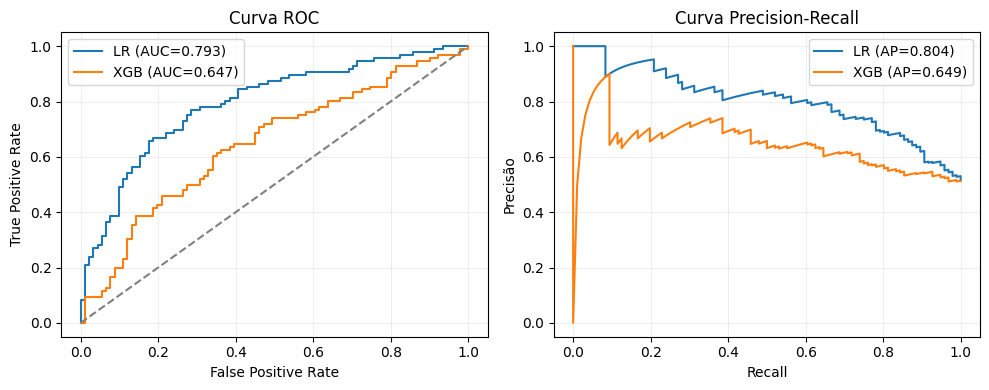

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={roc_auc_score(y_test, y_proba_lr):.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB (AUC={roc_auc_score(y_test, y_proba_xgb):.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(alpha=0.2)

plt.subplot(1,2,2)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_proba_lr)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
plt.plot(rec_lr, prec_lr, label=f"LR (AP={average_precision_score(y_test, y_proba_lr):.3f})")
plt.plot(rec_xgb, prec_xgb, label=f"XGB (AP={average_precision_score(y_test, y_proba_xgb):.3f})")
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall")
plt.legend()
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

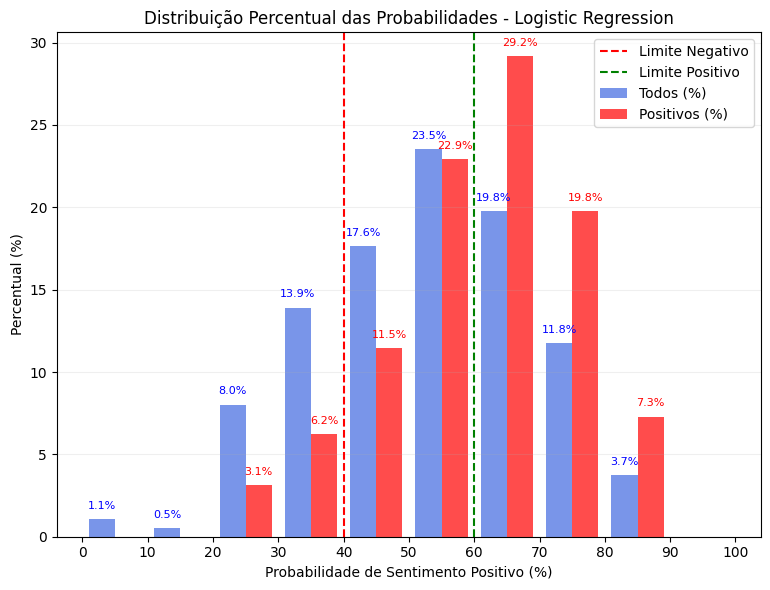

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

step = 0.1
bins = np.arange(0, 1 + step, step)
threshold_neg = 0.4
threshold_pos = 0.6

def plot_distribuicao(y_true, y_pred_proba, nome_modelo):
    """
    Cria o gráfico de distribuição percentual das probabilidades
    mostrando TODAS as previsões vs. amostras realmente positivas.
    """
    hist_all, _ = np.histogram(y_pred_proba, bins=bins)
    hist_pos, _ = np.histogram(y_pred_proba[y_true == 1], bins=bins)

    hist_all_pct = (hist_all / hist_all.sum()) * 100
    hist_pos_pct = (hist_pos / hist_pos.sum()) * 100

    x = (bins[:-1] + bins[1:]) / 2
    width = step * 0.4

    plt.bar(x - width/2, hist_all_pct, width=width, label='Todos (%)', alpha=0.7, color='royalblue')
    plt.bar(x + width/2, hist_pos_pct, width=width, label='Positivos (%)', alpha=0.7, color='red')

    for xi, val in zip(x - width/2, hist_all_pct):
        if val > 0:
            plt.text(xi, val + 0.5, f"{val:.1f}%", ha='center', va='bottom', fontsize=8, color='blue')
    for xi, val in zip(x + width/2, hist_pos_pct):
        if val > 0:
            plt.text(xi, val + 0.5, f"{val:.1f}%", ha='center', va='bottom', fontsize=8, color='red')

    plt.axvline(threshold_neg, color='red', linestyle='--', label='Limite Negativo')
    plt.axvline(threshold_pos, color='green', linestyle='--', label='Limite Positivo')

    plt.xlabel('Probabilidade de Sentimento Positivo (%)')
    plt.ylabel('Percentual (%)')
    plt.title(f'Distribuição Percentual das Probabilidades - {nome_modelo}')
    plt.xticks(np.arange(0, 1.1, 0.1), [f'{int(v*100)}' for v in np.arange(0, 1.1, 0.1)])
    plt.legend()
    plt.grid(axis='y', alpha=0.2)


plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plot_distribuicao(y_test, y_proba_lr, "Logistic Regression")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

def avaliar_com_threshold(nome, y_true, y_proba, threshold=0.5):
    """
    Avalia o modelo usando um ponto de corte (threshold) customizado.
    """
    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    aucroc = roc_auc_score(y_true, y_proba)
    aucpr = average_precision_score(y_true, y_proba)

    print(f"\n== {nome} com threshold = {threshold} ==")
    print(f"Acurácia: {acc:.4f}")
    print(f"Precisão: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"AUC-ROC: {aucroc:.4f}")
    print(f"AUC-PR (AP): {aucpr:.4f}")

    return {
        'threshold': threshold,
        'acc': acc,
        'prec': prec,
        'rec': rec,
        'f1': f1,
        'aucroc': aucroc,
        'aucpr': aucpr
    }

In [ ]:
for th in [0.4, 0.6]:
    avaliar_com_threshold("Logistic Regression", y_test, y_proba_lr, threshold=th)


== Logistic Regression com threshold = 0.4 ==
Acurácia: 0.6524
Precisão: 0.6084
Recall: 0.9062
F1: 0.7280
AUC-ROC: 0.7933
AUC-PR (AP): 0.8045

== Logistic Regression com threshold = 0.6 ==
Acurácia: 0.7112
Precisão: 0.8182
Recall: 0.5625
F1: 0.6667
AUC-ROC: 0.7933
AUC-PR (AP): 0.8045


# Relatório de Avaliação de Modelos de Classificação de Sentimentos (Base Imdb)

## 1. Modelos Treinados
- Logistic Regression  
- XGBoost  

___

## 2. Métricas Obtidas

| Modelo | Acurácia | Precisão | Recall | F1 | AUC-ROC | AUC-PR |
|:--|:--:|:--:|:--:|:--:|:--:|:--:|
| Logistic Regression | **0.711* | **0.690** | **0.791** | **0.737** | **0.793** | **0.804** |
| XGBoost | 0.625 | 0.618 | 0.708 | 0.660 | 0.647 | 0.648 |

___

## 3. Análise dos Resultados

- A **Regressão Logística** superou o **XGBoost** em **todas as métricas principais**, mostrando melhor equilíbrio entre precisão e recall.  
- O **AUC-ROC (0.793)** e o **AUC-PR (0.804)** indicam boa separação entre as classes e **probabilidades mais calibradas**.  
- As curvas ROC e Precision-Recall mostram que a RL mantém **maior área sob a curva**, reforçando sua capacidade de generalização.  
- O **XGBoost**, mesmo com boa configuração, apresentou **maior dispersão nas probabilidades** e tendência a **overfitting**, o que reduziu seu desempenho em dados de teste.

___

## 4. Conclusão

O modelo **Logistic Regression** é o **mais adequado** para esta base de sentimentos balanceada.  
Ele apresentou:
- **Melhor desempenho global** (maiores F1, AUC-ROC e AUC-PR);  
- **Probabilidades mais calibradas** e interpretáveis;  
- **Maior estabilidade e robustez** em dados TF-IDF.  

✅ **Modelo Recomendado:** Logistic Regression